# Rasterize and vectorize

This tutorial illustrates how to convert a segmentation mask (array) into its vectorized form, and segmentation boundaries (polygons) into their rasterized equivalents. This conversion is useful, for example, when integrating annotations (e.g., from [QuPath](https://qupath.github.io/)) into downstream spatial omics analysis.

For raster-to-vector conversion, we provide the function `harpy.sh.vectorize`, and for vector-to-raster conversion, we provide the function `harpy.im.rasterize`. These functions transform a labels layer (raster) in a SpatialData object into a shapes layer (polygons), and vice versa. They also manage coordinate systems and related transformations defined on the spatial elements automatically.

The `harpy.sh.vectorize` internally relies on the [rasterio](https://rasterio.readthedocs.io/en/stable/) library, while `harpy.im.rasterize` uses [Datashader](https://datashader.org/). Both functions are optimized with `Dask` for multi-core and out-of-core processing.

## 1. Example on dummy data

In [1]:
from spatialdata.datasets import blobs

sdata = blobs(length=1000, n_channels=3)

/home/VIB.LOCAL/arne.defauw/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_26_11_25/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Let's perform the following conversions: raster → vector → raster → vector, and check whether the results are consistent.

In [8]:
import harpy as hp

sdata = hp.sh.vectorize(
    sdata,
    labels_layer="blobs_labels",
    output_layer="blobs_labels_boundaries",
    overwrite=True,
)

sdata = hp.im.rasterize(
    sdata,
    shapes_layer="blobs_labels_boundaries",
    output_layer="blobs_labels_redo",
    chunks=1000,
    overwrite=True,
)

sdata = hp.sh.vectorize(
    sdata,
    labels_layer="blobs_labels_redo",
    output_layer="blobs_labels_boundaries_redo",
    overwrite=True,
)

2025-12-03 08:15:03.942 | INFO     | harpy.shape._manager:_mask_to_polygons_rasterio:339 - Finished vectorizing. Dissolving shapes at the border of the chunks. This can take a couple minutes if input mask contains many chunks.
2025-12-03 08:15:03.961 | INFO     | harpy.shape._manager:_mask_to_polygons_rasterio:345 - Dissolve is done.
2025-12-03 08:15:05.598 | INFO     | harpy.image._manager:add_layer:47 - Writing results to layer 'blobs_labels_redo'
2025-12-03 08:15:05.637 | INFO     | harpy.shape._manager:_mask_to_polygons_rasterio:339 - Finished vectorizing. Dissolving shapes at the border of the chunks. This can take a couple minutes if input mask contains many chunks.
2025-12-03 08:15:05.657 | INFO     | harpy.shape._manager:_mask_to_polygons_rasterio:345 - Dissolve is done.


We proceed to show that they are in fact equal:

In [10]:
display(sdata["blobs_labels_boundaries"].head())
display(sdata["blobs_labels_boundaries_redo"].head())

,geometry
cell_ID,
1,"MULTIPOLYGON (((801 41, 801 40, 800 40, 800 41..."
2,"MULTIPOLYGON (((681 591, 681 590, 680 590, 680..."
3,"POLYGON ((335 338, 335 339, 331 339, 331 341, ..."
4,"POLYGON ((181 600, 181 601, 176 601, 176 602, ..."
5,"MULTIPOLYGON (((429 267, 426 267, 426 268, 423..."


,geometry
cell_ID,
1,"MULTIPOLYGON (((801 41, 801 40, 800 40, 800 41..."
2,"MULTIPOLYGON (((681 591, 681 590, 680 590, 680..."
3,"POLYGON ((335 338, 335 339, 331 339, 331 341, ..."
4,"POLYGON ((181 600, 181 601, 176 601, 176 602, ..."
5,"MULTIPOLYGON (((429 267, 426 267, 426 268, 423..."


In [11]:
import numpy as np

assert np.array_equal(sdata["blobs_labels"].data.compute(), sdata["blobs_labels_redo"].data.compute())
assert sdata["blobs_labels_boundaries"].geometry.equals(sdata["blobs_labels_boundaries_redo"].geometry)

And finally a visual inspection.

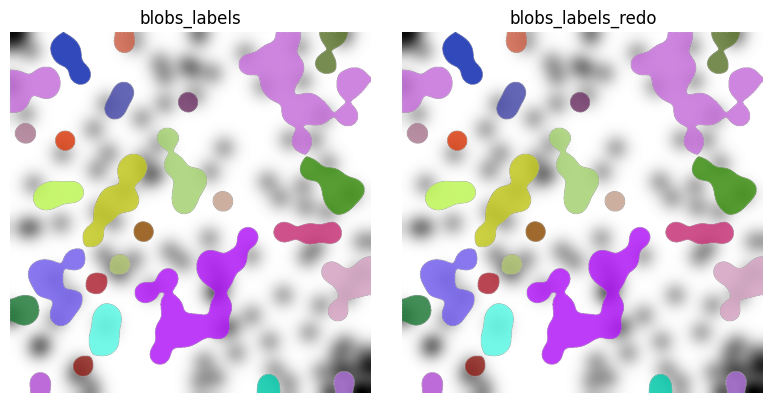

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = 0

render_images_kwargs = {"cmap": "binary"}

for _labels_layer, ax in zip(["blobs_labels", "blobs_labels_redo"], axes, strict=True):
    render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
    show_kwargs = {
        "title": "DAPI",
        "colorbar": False,
    }

    show_kwargs = {
        "title": _labels_layer,
        "colorbar": False,
    }
    ax = hp.pl.plot_sdata(
        sdata,
        img_layer="blobs_image",
        labels_layer="blobs_labels",
        channel=0,
        render_images_kwargs=render_images_kwargs,
        render_labels_kwargs=render_labels_kwargs,
        show_kwargs=show_kwargs,
        ax=ax,
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

Be advised that the transformation from raster to polygon formats, or vice versa, can yield small deviations attributable to numerical precision limitations. 

## 2. Example on MERSCOPE data.

In [1]:
import harpy as hp

sdata = hp.datasets.merscope_mouse_liver_segmentation_mask()

/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_26_11_25/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/data/groups/technologies/spatial.catalyst/Arne/harpy/src/harpy/datasets/transcriptomics.py:332: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  sdata = read_zarr(os.path.commonpath(unzip_path))
no parent found for <ome_zarr.reader.Label object at 0x7ff80ac18bc0>: None


We perform a roundtrip, raster → vector → raster, and visually check whether the resulting rasters look the same.

In [2]:
import dask

labels_layer = "segmentation_mask_full"
shapes_layer = "segmentation_mask_full_boundaries"

dask.config.set(scheduler="processes")

# takes 1m40 on MacOS (m2)
sdata = hp.sh.vectorize(
    sdata,
    labels_layer=labels_layer,
    output_layer=shapes_layer,
    overwrite=True,
)

print("Finished vectorizing.")

# latter code consumes a lot of ram because sdata is not backed in this example.
# back sdata to zarr store for low ram consumption

# set to threads for efficient processing, or define a dask client using few workers and threads.
dask.config.set(scheduler="threads")

# takes around 1m30 on MacOS (m2)
sdata = hp.im.rasterize(
    sdata,
    shapes_layer=shapes_layer,
    output_layer=labels_layer + "_redo",
    chunks=5000,
    overwrite=True,
)

print("Finished rasterizing.")

2025-12-02 21:10:19.157 | INFO     | harpy.shape._manager:_mask_to_polygons_rasterio:339 - Finished vectorizing. Dissolving shapes at the border of the chunks. This can take a couple minutes if input mask contains many chunks.
2025-12-02 21:11:34.460 | INFO     | harpy.shape._manager:_mask_to_polygons_rasterio:345 - Dissolve is done.


Finished vectorizing.


2025-12-02 21:13:27.696 | INFO     | harpy.image._manager:add_layer:47 - Writing results to layer 'segmentation_mask_full_redo'


Finished rasterizing.


Visual inspection.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


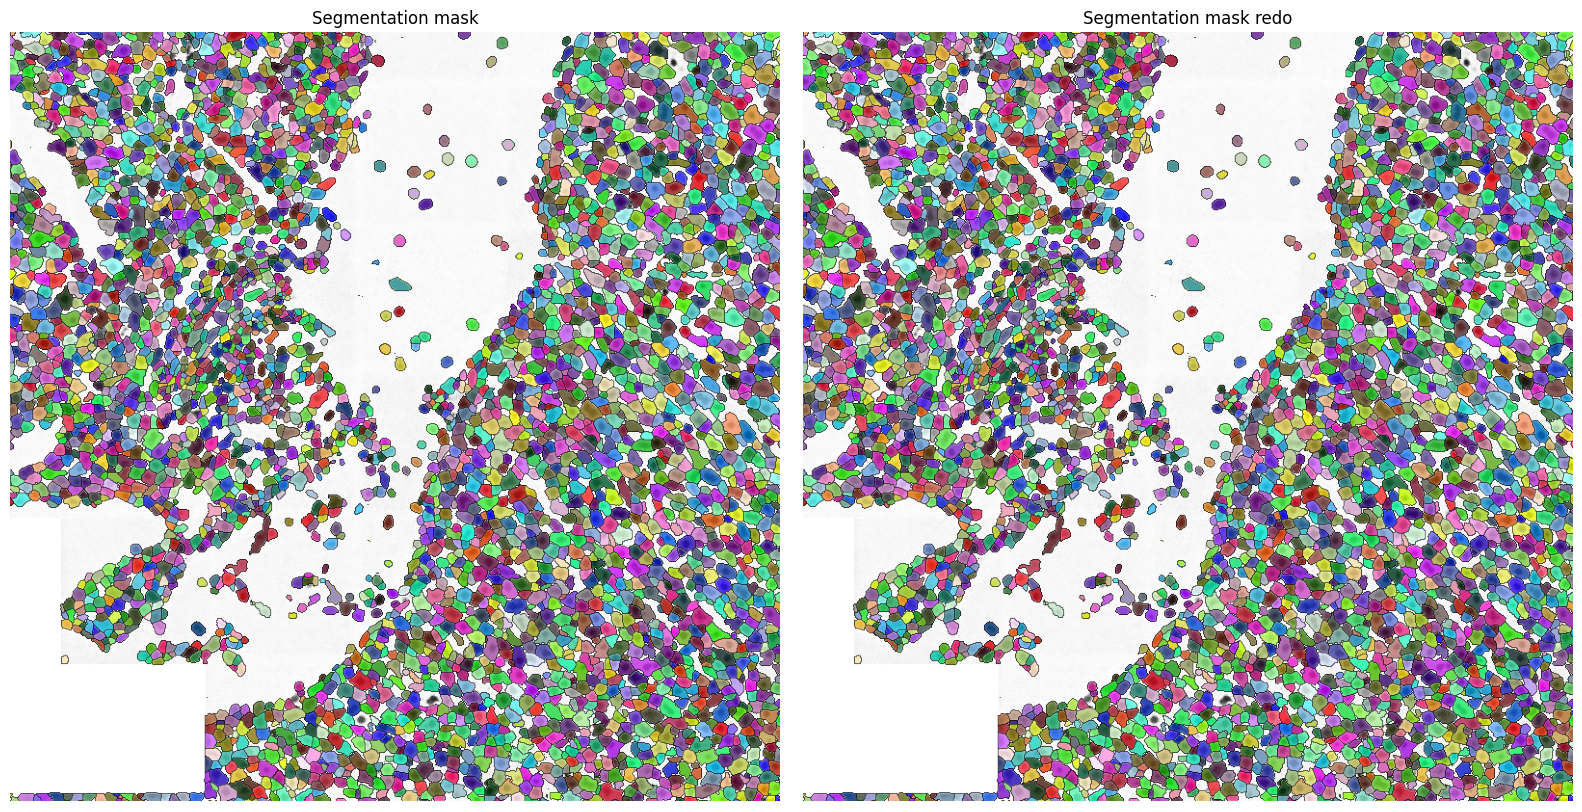

In [7]:
import matplotlib.pyplot as plt

img_layer = "clahe"
labels_layer = "segmentation_mask_full"

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

channel = 0

render_images_kwargs = {"cmap": "binary"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

for _labels_layer, ax in zip(["segmentation_mask_full", "segmentation_mask_full_redo"], axes, strict=True):
    # subset, because query is slow on points layer
    sdata_to_plot = sdata.subset(element_names=[img_layer, _labels_layer])

    color = channel
    show_kwargs = {
        "title": "Segmentation mask" if _labels_layer == "segmentation_mask_full" else "Segmentation mask redo",
        "colorbar": False,
    }
    ax = hp.pl.plot_sdata(
        sdata_to_plot,
        img_layer=img_layer,
        channel=channel,
        labels_layer=_labels_layer,
        crd=[20000, 30000, 20000, 30000],
        render_images_kwargs=render_images_kwargs,
        render_labels_kwargs=render_labels_kwargs,
        show_kwargs=show_kwargs,
        to_coordinate_system="global",
        ax=ax,
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

Again, both segmentation masks look very similar.